In [16]:
%matplotlib inline
import pandas as pd
import numpy as np
from netCDF4 import Dataset
import os, time, datetime
from datetime import date
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.layers import Dense, LSTM, Activation, Dropout
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import warnings

In [17]:
# it looks like XGBoost is using a library that's a bit older, silencing the deprication warning
warnings.filterwarnings("ignore")

In [18]:
labels = pd.read_csv('data/Labels/mhwLabels_30n120w.csv')

In [19]:
# labels data are currently one per column
labels.head()

,1981-09-01,1981-09-02,1981-09-03,1981-09-04,1981-09-05,1981-09-06,1981-09-07,1981-09-08,1981-09-09,1981-09-10,...,2018-06-02,2018-06-03,2018-06-04,2018-06-05,2018-06-06,2018-06-07,2018-06-08,2018-06-09,2018-06-10,2018-06-11
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# transform labels into a two column dataset with date and label
labels = labels.melt()

In [21]:
# give more relatable column names
labels.rename(columns={'variable':'date','value':'label'},inplace=True)
labels.head()

,date,label
0,1981-09-01,0.0
1,1981-09-02,0.0
2,1981-09-03,0.0
3,1981-09-04,0.0
4,1981-09-05,0.0


In [24]:
def load_data(x):
    fp = 'data/' # <- change this to your path
    if x != 'air':
        data = Dataset(fp+x+'_'+'30n120w.nc') # reading the netCDF file and creating a dataset
    else:
         data = Dataset(fp+'airt'+'_'+'30n120w.nc') # correct for the fact that the file is called airt but the var is air
            
    # pull out selected variable   
    value = np.squeeze(data.variables[x][:])
    
    # Time (days since)
    f_time = data.variables['time'][:] # time is given in days since 1800-01-01 00:00:00
    if x == 'sst':
        ref = datetime.date(1800, 1, 1).toordinal()
    else:
        ref = datetime.date(1, 1, 1).toordinal()
    time = ref+f_time # adjust time as days since 0000-01-01 00:00:00

    # Dates (yyyy-mm-dd)
    dates = [date.fromordinal(tt.astype(int)) for tt in time]
    dates = np.array(dates)
    
    # Create a python series
    data = pd.DataFrame({'date':dates,str(x):value})
    return data

In [25]:
sst = load_data('sst')
rhum = load_data('rhum')
slp = load_data('slp')
uwnd = load_data('uwnd')
vwnd = load_data('vwnd')
airt = load_data('air')

In [26]:
#rename
df = labels

In [28]:
#combine all values
#value_df = value_df.join([rhum,slp,uwnd,vwnd], on='date', how='inner')
value_df = sst.merge(rhum, on='date')
value_df = value_df.merge(slp, on='date')
value_df = value_df.merge(uwnd, on='date')
value_df = value_df.merge(vwnd, on='date')
value_df = value_df.merge(airt, on='date')
value_df.head()

,date,sst,rhum,slp,uwnd,vwnd,air
0,1981-09-01,18.559999,80.059998,1006.420044,0.889999,-5.889999,295.010010
1,1981-09-02,18.629999,80.190002,1006.920044,0.599991,-5.520004,294.209991
2,1981-09-03,18.400000,80.309998,1007.420044,0.309998,-5.149994,293.399994
3,1981-09-04,18.359999,80.440002,1007.920044,0.020004,-4.779999,292.599976
4,1981-09-05,19.049999,80.569992,1008.420044,-0.270004,-4.419998,291.799988


In [29]:
df = df.merge(value_df, how='inner', left_index=True, right_index=True)

In [30]:
# for each day in the dataset, loop back some number of days and report the SST for that day as a new column. 
# This loop creates a new column for each of the 40 previous days

look_back = pd.DataFrame()
back_range = [i+1 for i in range(40)]
for feat in ['rhum','slp','sst','uwnd','vwnd','air']:
    for day in back_range:
        sst_back = []
        for i in range(len(df)):
            if i-day < 0:
                sst_back.append(0)
            else:
                sst_back.append(df[feat][i-day])
        look_back[feat+'-'+str(day)] = sst_back

In [31]:
# for each day in the dataset, loop forward some number of days and check if there was a heatwave in that range
# If there was a heatwave, in any of the next 30 days, mark the column heat_30 as 1 else 0
# this allows prediction on a give day: will there be a heatwave in the next 30 days

heat_30 = np.zeros(len(df))
forward_range = [i+1 for i in range(30)]
for i in range(len(df)):
    event = 0
    for day in forward_range:
        if day+i >= len(df):
            event += 0
        else:
            event += df['label'][day+i]
    if event > 0:
        heat_30[i] = 1
    else:
        heat_30[i] = 0

In [32]:
# make the heat_30 column a single column dataframe
heat_30 = pd.DataFrame({'heat_30':heat_30})

In [33]:
# join the labels, backward lookin SST columns, and forward looking heatwave column together on their index
# all are the same length and in chronological order so this should work directly
result = pd.concat([df, look_back,heat_30], axis=1, join='inner')
result.head()

,date_x,label,date_y,sst,rhum,slp,uwnd,vwnd,air,rhum-1,...,air-32,air-33,air-34,air-35,air-36,air-37,air-38,air-39,air-40,heat_30
0,1981-09-01,0.0,1981-09-01,18.559999,80.059998,1006.420044,0.889999,-5.889999,295.010010,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1981-09-02,0.0,1981-09-02,18.629999,80.190002,1006.920044,0.599991,-5.520004,294.209991,80.059998,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1981-09-03,0.0,1981-09-03,18.400000,80.309998,1007.420044,0.309998,-5.149994,293.399994,80.190002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1981-09-04,0.0,1981-09-04,18.359999,80.440002,1007.920044,0.020004,-4.779999,292.599976,80.309998,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1981-09-05,0.0,1981-09-05,19.049999,80.569992,1008.420044,-0.270004,-4.419998,291.799988,80.440002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
# drop off the first 40 and last 30 sample days
# these have data that were artificially set to 0 and so shouldn't be included
# dropping 70 rows shouldn't effect the overall dataset quality
result.drop(df.index[:40], inplace=True)
result.drop(df.index[-30:], inplace=True)
result.head()

,date_x,label,date_y,sst,rhum,slp,uwnd,vwnd,air,rhum-1,...,air-32,air-33,air-34,air-35,air-36,air-37,air-38,air-39,air-40,heat_30
40,1981-10-11,0.0,1981-10-11,19.379999,72.959991,1014.020020,2.270004,-2.520004,289.630005,74.600006,...,290.479980,288.250000,290.190002,291.000000,291.799988,292.599976,293.399994,294.209991,295.010010,0.0
41,1981-10-12,0.0,1981-10-12,19.330000,71.319992,1014.070007,2.209991,-2.649994,289.809998,72.959991,...,294.720001,290.479980,288.250000,290.190002,291.000000,291.799988,292.599976,293.399994,294.209991,0.0
42,1981-10-13,0.0,1981-10-13,19.240000,81.319992,1014.190063,1.319992,-1.580002,287.940002,71.319992,...,299.169983,294.720001,290.479980,288.250000,290.190002,291.000000,291.799988,292.599976,293.399994,0.0
43,1981-10-14,0.0,1981-10-14,19.879999,85.259995,1014.400024,3.089996,-5.360001,289.390015,81.319992,...,297.299988,299.169983,294.720001,290.479980,288.250000,290.190002,291.000000,291.799988,292.599976,0.0
44,1981-10-15,0.0,1981-10-15,20.000000,81.470001,1013.520020,4.270004,-4.089996,287.989990,85.259995,...,293.089996,297.299988,299.169983,294.720001,290.479980,288.250000,290.190002,291.000000,291.799988,0.0


In [36]:
result.to_csv('featurized_data')

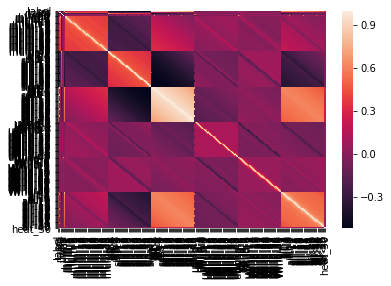

In [37]:
# just curious, do the days correlate with each other?
# yes they seem to
corr = result.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [38]:
#split the data into targets and features, dropping unneeded values
y = result['heat_30'].astype('int')
X = result.drop(['label','sst', 'date_x','date_y', 'heat_30','rhum','slp','uwnd','vwnd','air'], axis=1)

In [39]:
X = np.nan_to_num(X)

In [40]:
#split into a training and test set, ensuring to stratify the class breakdowns between sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [41]:
#instantiate a gradient boosted machine for classification
gbm = xgb.XGBClassifier(verbose=True, subsample=0.2, n_jobs=7, n_estimators=3000)

In [42]:
gbm.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=3000,
       n_jobs=7, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.2, verbose=True)

In [45]:
#this is a highly class imbalanced problem, so we should experiment with different thresholds.
#very few heatwaves will likely spike to above 50% probability, but we can catch them by lowering the probablility threshold
#we don't want to lower it too far though, because we will catch too many false positives.

threshold = 0.2
preds = gbm.predict_proba(X_test)[:,1]
pred = []
for i in range(len(preds)):
    if preds[i] > threshold:
        pred.append(1)
    else:
        pred.append(0)

In [46]:
#eval model performance
print(classification_report(y_test,pred))
print(confusion_matrix(y_test,pred))

             precision    recall  f1-score   support

          0       0.95      0.96      0.96      2311
          1       0.73      0.69      0.71       362

avg / total       0.92      0.92      0.92      2673

[[2218   93]
 [ 112  250]]


In [47]:
all_pred = pd.DataFrame({'pred':gbm.predict(X),'proba':gbm.predict_proba(X)[:,1]})
result = pd.concat([df, all_pred,heat_30], axis=1, join='inner')
result.to_csv('output.csv')

In [48]:
# the following section should be used if you want to precision tune the gbm -------------------

In [49]:
#parameters = {'max_depth': [4,6,8], 'n_estimators': [2000, 2500, 3000, 4000], 'learning_rate': [0.005, 0.01, 0.02, 0.03, 0.05]}

In [50]:
#clf = GridSearchCV(gbm, parameters, cv=5, verbose=True, scoring='recall')
#clf.fit(X_train, y_train)

In [51]:
#preds = clf.predict(X_test)

In [52]:
#print(classification_report(y_test,preds))
#print(confusion_matrix(y_test,preds))

In [53]:
# end precision tuning section ----------------------

In [54]:
# try a dense NN model 

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [66]:
scl = MinMaxScaler(feature_range=(-1, 1))
X_train = scl.fit_transform(X_train)
X_test = scl.transform(X_test)

In [67]:
class_weight = {0: 1.,
                1: 1.}

In [68]:
model = Sequential()

In [69]:
model.add(Dense(512, activation='relu', input_shape=(240,)))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [70]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [71]:
model.fit(X_train,
         y_train,
         epochs=50,
         batch_size=512,
         class_weight=class_weight)

Epoch 1/50
10690/10690 [==============================] - 1s 136us/step - loss: 0.3783 - acc: 0.8507
Epoch 2/50
10690/10690 [==============================] - 0s 10us/step - loss: 0.3142 - acc: 0.8832
Epoch 3/50
10690/10690 [==============================] - 0s 11us/step - loss: 0.2931 - acc: 0.8906
Epoch 4/50
10690/10690 [==============================] - 0s 10us/step - loss: 0.2779 - acc: 0.8920
Epoch 5/50
10690/10690 [==============================] - 0s 11us/step - loss: 0.2632 - acc: 0.9019
Epoch 6/50
10690/10690 [==============================] - 0s 10us/step - loss: 0.2463 - acc: 0.9042
Epoch 7/50
10690/10690 [==============================] - 0s 10us/step - loss: 0.2242 - acc: 0.9148
Epoch 8/50
10690/10690 [==============================] - 0s 11us/step - loss: 0.2041 - acc: 0.9250
Epoch 9/50
10690/10690 [==============================] - 0s 10us/step - loss: 0.1865 - acc: 0.9309
Epoch 10/50
10690/10690 [==============================] - 0s 11us/step - loss: 0.1643 - acc: 0.938

In [85]:
threshold = 0.3
preds = model.predict_proba(X_test)
pred = []
for i in range(len(preds)):
    if preds[i] > threshold:
        pred.append(1)
    else:
        pred.append(0)

In [86]:
print(classification_report(y_test,pred))
print(confusion_matrix(y_test,pred))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99      2311
          1       0.97      0.88      0.93       362

avg / total       0.98      0.98      0.98      2673

[[2302    9]
 [  42  320]]


In [74]:
X_scl = scl.transform(X)

In [75]:
pred = [x[0] for x in model.predict(X_scl)]
proba = [x[0] for x in model.predict_proba(X_scl)]

In [76]:
all_pred = pd.DataFrame({'pred':pred,'proba':proba})
result = pd.concat([df, all_pred, heat_30], axis=1, join='inner')
result.to_csv('output_NN.csv')